In [622]:
import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.exceptions import DataConversionWarning

# Suppress specific warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# Or to ignore all warnings
warnings.filterwarnings(action='ignore')



# Prediction Spinal Fusion Surgery Outcome using Electronic Health Records in MOVER dataset

This project aims to data in the MOVER dataset to train ensemble models to predict surgery outcome for scoliosis patient who did fusion surgery. This notebook report shows the entire process of data analyzing, data preprocessing, model building, model running, and analysis on prediction result. There will be note along the code discussing my observations after each step and explaining the reason behind each decision. The result analysis is at the Model Training and Result Analysis section at the end of the report.


## Importing EPIC data in the MOVER Dataset
Mover dataset contains data collected from EPIC and SIS EHR system, containing high-fidelity physiological waveforms from all of the operating rooms were captured in real time and matched with Electronic Medical Record Data. 
Dataset link: https://archive.ics.uci.edu/dataset/877/mover:+medical+informatics+operating+room+vitals+and+events+repository
In this project, I will work with only data from EPIC system, since it patient post operational complication information, which SIS does not contain. This piece of data is crutial for this project, since it indirectly shows whether a patient's surgery result is good or bad.

In [2]:
data_dir = "/datadrive/YiningData/mover-download.ics.uci.edu/"
read_rows = 1000000  # Number of rows to read
epic_patient_info = pd.read_csv(data_dir + "EPIC_EMR/patient_information.csv")

In [219]:
epic_patient_info = pd.read_csv(data_dir + "EPIC_EMR/patient_information.csv")
# Load EPIC_EMR CSV files into pandas DataFrames
epic_patient_coding = pd.read_csv(data_dir + "EPIC_EMR/patient_coding.csv", nrows=read_rows)
epic_patient_history = pd.read_csv(data_dir + "EPIC_EMR/patient_history.csv", nrows=read_rows)
epic_patient_labs = pd.read_csv(data_dir + "EPIC_EMR/patient_labs.csv", nrows=read_rows)
epic_patient_lda = pd.read_csv(data_dir + "EPIC_EMR/patient_lda.csv", nrows=read_rows)
epic_patient_medications = pd.read_csv(data_dir + "EPIC_EMR/patient_medications.csv", nrows=read_rows)
epic_post_op_complications = pd.read_csv(data_dir + "EPIC_EMR/patient_post_op_complications.csv", nrows=read_rows)
epic_patient_procedure_events = pd.read_csv(data_dir + "EPIC_EMR/patient_procedure events.csv", nrows=read_rows)
epic_patient_visits = pd.read_csv(data_dir + "EPIC_EMR/patient_visit.csv", nrows=read_rows)

In [4]:
dfs = {
    'epic_patient_info': epic_patient_info,
    'epic_patient_coding': epic_patient_coding,
    'epic_patient_history': epic_patient_history,
    'epic_patient_labs': epic_patient_labs,
    'epic_patient_lda': epic_patient_lda,
    'epic_patient_medications': epic_patient_medications,
    'epic_post_op_complications': epic_post_op_complications,
    'epic_patient_procedure_events': epic_patient_procedure_events,
    'epic_patient_visits': epic_patient_visits
}

for name, df in dfs.items():
    table_size = df.shape  # Get the size of the table (rows, columns)
    print(f"\nAttributes in {name}: (Table size: {table_size[0]} rows, {table_size[1]} columns)")
    print("-" * (len(name) + 15))  # Neat separator
    print(list(df.columns))  # Print columns in a list format



Attributes in epic_patient_info: (Table size: 65728 rows, 23 columns)
--------------------------------
['LOG_ID', 'MRN', 'DISCH_DISP_C', 'DISCH_DISP', 'HOSP_ADMSN_TIME', 'HOSP_DISCH_TIME', 'LOS', 'ICU_ADMIN_FLAG', 'SURGERY_DATE', 'BIRTH_DATE', 'HEIGHT', 'WEIGHT', 'SEX', 'PRIMARY_ANES_TYPE_NM', 'ASA_RATING_C', 'ASA_RATING', 'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM', 'PRIMARY_PROCEDURE_NM', 'IN_OR_DTTM', 'OUT_OR_DTTM', 'AN_START_DATETIME', 'AN_STOP_DATETIME']

Attributes in epic_patient_coding: (Table size: 1000000 rows, 6 columns)
----------------------------------
['MRN', 'SOURCE_KEY', 'SOURCE_NAME', 'NAME', 'REF_BILL_CODE_SET_NAME', 'REF_BILL_CODE']

Attributes in epic_patient_history: (Table size: 970741 rows, 3 columns)
-----------------------------------
['mrn', 'diagnosis_code', 'dx_name']

Attributes in epic_patient_labs: (Table size: 1000000 rows, 10 columns)
--------------------------------
['LOG_ID', 'MRN', 'ENC_TYPE_NM', 'Lab Code', 'Lab Name', 'Observation Value', 'Measurem

### Observation: Potential ways to filter out the target scoliosis patients
#### 1. filter on scoliosis diagnosis code-> then use the code to index on patient visit dataset
After taking look at the each dataset attributes, I believe to filter out all scoliosis patient, I should starting from identifying diagnosis code that are related to scoliosis from the patient coding table, then using the full list of diagnosis codes to filter on patient visit table, which also contains diagnosis code attribute. This introduces a layer of complexity since there needs to be multiple filters and merging, however it would be technically the best way to get all possible related records.

#### 2. filter on patient_information table, finding 'primary procedure'that contains scoliosis keywords
Another method to take is to look at the patient information tabel and filter on PRIMARY_PROCEDURE that contains keywords such as 'scoliosis' or 'spinal fusion'. This might be good because patient information table is the main table that contains all patient information, which means the filtering result is most straight forwardly related to the data I will use for prediction task.

#### 3. filter on patient_visit table, directly use the dignosis name 
Last potential method I could think of is filtering directly on diagnosis name in the patient visit table. The result should contain most relevant data, however it is not garanteed to contain all possible cases.

### ATTEMPT 1: filter on scoliosis diagnosis code-> then use the code to index on patient visit dataset

In [5]:
# Filter rows where 'NAME' contains the keyword "spine" (case-insensitive)
spine_related_procedures = epic_patient_history[epic_patient_history['dx_name'].str.contains('scoliosis', case=False, na=False)]

spine_procedures_with_history = pd.merge(spine_related_procedures, epic_patient_history, left_on='mrn',right_on='mrn', how='inner')
spine_procedures_with_history

,mrn,diagnosis_code_x,dx_name_x,diagnosis_code_y,dx_name_y
0,b802bdc56a852253,737.30,Neuromuscular scoliosis,737.30,Neuromuscular scoliosis
1,b802bdc56a852253,737.30,Neuromuscular scoliosis,493.90,Asthma
2,b802bdc56a852253,737.30,Neuromuscular scoliosis,348.9,Disorder of brain
3,b802bdc56a852253,737.30,Neuromuscular scoliosis,NaN,Gastrointestinal tube present (CMS-HCC)
4,b802bdc56a852253,737.30,Neuromuscular scoliosis,737.30,Kyphoscoliosis deformity of spine
...,...,...,...,...,...
57719,4c020d74e5c34793,NaN,"Scoliosis, unspecified scoliosis type, unspeci...",726.5,Femoral acetabular impingement
57720,4c020d74e5c34793,NaN,"Scoliosis, unspecified scoliosis type, unspeci...",NaN,"Irritable bowel syndrome, unspecified type"
57721,4c020d74e5c34793,NaN,"Scoliosis, unspecified scoliosis type, unspeci...",NaN,Raynaud's disease without gangrene
57722,4c020d74e5c34793,NaN,"Scoliosis, unspecified scoliosis type, unspeci...",789.03,"Abdominal pain, chronic, right lower quadrant"


### Observation: diagnosis name not matching
I noticed that even after filtering on scoliosis keyword for diagnosis name in patient history table, this doesn't garantee that the diagnosis code found in patient coding table are all for scoliosis patient. I believe this is a potential source of noise in the dataset. Therefore I would attempt to filter through other methods

### ATTEMPT 2: filter on patient_information table, finding 'primary procedure'that contains scoliosis keywords


In [6]:
# List of keywords related to spinal surgeries
spinal_keywords = ["FUSION, SPINE","scoliosis"]

# Filter rows in the dataframe where the procedure contains any spinal-related keyword
filtered_spinal_surgeries = epic_patient_info[epic_patient_info['PRIMARY_PROCEDURE_NM'].str.contains('|'.join(spinal_keywords), case=False, na=False)]

# Display the filtered DataFrame
filtered_spinal_surgeries


,LOG_ID,MRN,DISCH_DISP_C,DISCH_DISP,HOSP_ADMSN_TIME,HOSP_DISCH_TIME,LOS,ICU_ADMIN_FLAG,SURGERY_DATE,BIRTH_DATE,...,PRIMARY_ANES_TYPE_NM,ASA_RATING_C,ASA_RATING,PATIENT_CLASS_GROUP,PATIENT_CLASS_NM,PRIMARY_PROCEDURE_NM,IN_OR_DTTM,OUT_OR_DTTM,AN_START_DATETIME,AN_STOP_DATETIME
26,5a95970d5c8fc355,0a8b72c1cec4ae47,15.0,Home Routine,11/18/18 5:34,11/28/18 16:20,10.0,Yes,11/18/18 0:00,57,...,General,3.0,Severe Systemic Disease,Inpatient,Hospital Inpatient Surgery,"FUSION, SPINE, LUMBAR, ANTERIOR APPROACH",11/18/18 8:12,11/18/18 14:52,11/18/18 8:12,11/18/18 15:01
38,d121bdb0a955b7c6,789ded02c719838b,100.0,Rehab Facility (this hospital),8/10/19 8:47,8/17/19 12:38,7.0,Yes,8/10/19 0:00,78,...,General,2.0,Mild Systemic Disease,Inpatient,Hospital Inpatient Surgery,"FUSION, SPINE, LUMBAR AND LUMBOSACRAL, USING P...",8/10/19 10:16,8/10/19 15:01,8/10/19 10:16,8/10/19 15:07
52,3.44E+15,c3ce84c4f165f902,100.0,Rehab Facility (this hospital),1/11/20 6:07,1/20/20 13:56,9.0,No,1/11/20 0:00,80,...,General,3.0,Severe Systemic Disease,Inpatient,Hospital Inpatient Surgery,"FUSION, SPINE, XLIF, ANTERIOR RETROPERITONEAL ...",1/11/20 8:13,1/11/20 12:20,1/11/20 8:13,1/11/20 12:29
119,3b27c25adbf2e689,b09fcd76e048c6a1,15.0,Home Routine,5/3/19 6:01,5/4/19 14:02,1.0,No,5/3/19 0:00,70,...,General,3.0,Severe Systemic Disease,Inpatient,Hospital Inpatient Surgery,"DECOMPRESSION AND FUSION, SPINE, CERVICAL, ANT...",5/3/19 7:11,5/3/19 10:15,5/3/19 7:11,5/3/19 10:22
123,c4b5629ed4850f96,acd9b60117d45514,15.0,Home Routine,4/28/19 13:01,5/1/19 10:46,3.0,No,4/28/19 0:00,63,...,General,3.0,Severe Systemic Disease,Inpatient,Hospital Inpatient Surgery,"FUSION, SPINE, LUMBAR AND LUMBOSACRAL, USING P...",4/28/19 21:14,4/29/19 2:42,4/28/19 21:14,4/29/19 2:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65350,0d85bfcd563b48ab,b8bcbdfee198e97f,100.0,Rehab Facility (this hospital),10/17/22 14:26,10/23/22 19:36,6.0,Yes,10/20/22 0:00,84,...,General,3.0,Severe Systemic Disease,Inpatient,Inpatient Admission,"FUSION, SPINE, LUMBAR, PLIF",10/20/22 7:30,10/20/22 11:28,10/20/22 7:30,10/20/22 11:30
65440,c3b0bf319f7d06d5,9b31932cb06c9a3d,20.0,Home Healthcare IP Admit Related,6/26/22 11:44,7/5/22 17:45,9.0,No,6/29/22 0:00,25,...,General,3.0,Severe Systemic Disease,Inpatient,Inpatient Admission,"FUSION, SPINE, CERVICAL, POSTERIOR APPROACH",6/29/22 7:15,6/29/22 11:40,6/29/22 7:14,6/29/22 11:47
65470,6125f535534ed5e2,3a5cdf5a8bfa1c6e,6.0,Skilled Nursing Facility,6/2/21 19:03,6/8/21 12:42,6.0,No,6/3/21 0:00,84,...,General,3.0,Severe Systemic Disease,Inpatient,Inpatient Admission,"FUSION, SPINE, THORACIC",6/3/21 14:22,6/3/21 19:54,6/3/21 14:22,6/3/21 20:03
65715,c755d794568d2736,ff51c972f657bea1,15.0,Home Routine,3/14/22 10:37,3/20/22 12:05,6.0,No,3/14/22 0:00,55,...,General,2.0,Mild Systemic Disease,Inpatient,Hospital Inpatient Surgery,"FUSION, SPINE, LUMBAR AND LUMBOSACRAL, USING P...",3/14/22 13:04,3/14/22 18:58,3/14/22 13:05,3/14/22 19:07


Unique procedure label related to spinal fusion surgery

In [7]:
unique_spinal_procedures = filtered_spinal_surgeries['PRIMARY_PROCEDURE_NM'].unique()

unique_spinal_procedures

array(['FUSION, SPINE, LUMBAR, ANTERIOR APPROACH',
       'FUSION, SPINE, LUMBAR AND LUMBOSACRAL, USING POSTERIOR TECHNIQUE',
       'FUSION, SPINE, XLIF, ANTERIOR RETROPERITONEAL APPROACH',
       'DECOMPRESSION AND FUSION, SPINE, CERVICAL, ANTERIOR APPROACH',
       'FUSION, SPINE, LUMBAR, INTERBODY',
       'FUSION, SPINE, THORACIC OR LUMBAR, OR BOTH THORACIC AND LUMBAR, POSTERIOR APPROACH, USING INSTRUMENTATION',
       'FUSION, SPINE, CERVICAL, POSTERIOR APPROACH',
       'FUSION, SPINE, THORACOLUMBAR, POSTERIOR APPROACH, USING INSTRUMENTATION',
       'FUSION, SPINE, CERVICAL, ANTERIOR APPROACH',
       'FUSION, SPINE, LUMBAR AND LUMBOSACRAL, ANTERIOR APPROACH',
       'FUSION, SPINE, THORACIC', 'FUSION, SPINE, WITH IMAGING GUIDANCE',
       'FUSION, SPINE, ANTERIOR ABDOMINAL APPROACH',
       'FUSION, SPINE, LUMBAR, PLIF',
       'FUSION, SPINE, THORACOLUMBAR, POSTERIOR APPROACH, WITH IMAGING GUIDANCE',
       'FUSION, SPINE, LUMBAR, PLIF, WITH LAMINECTOMY',
       'FUSION, SPIN

### Observation
The table generated through filtering on keywords shows that there are 1147 records related to patient doing fusion surgery. Though this is relatively limited, it is promised to be relevant to spinal fusion surgery for scoliosis patient. Another observation is on the procedure labeling: EPIC has a very structured and short labeling for surgery type, which is very helpful for task using traditional ML classifiers.

### ATTEMPT 3: Filter on patient_visit table, directly use the dignosis name

In [8]:
epic_patient_visits
# List of keywords related to spinal surgeries
spinal_keywords = ["scoliosis", "fusion"]

filtered_scoliosis_patient = epic_patient_visits[
    epic_patient_visits['dx_name'].str.contains('scoliosis', case=False, na=False) |
    (epic_patient_visits['dx_name'].str.contains('fusion', case=False, na=False) & 
     epic_patient_visits['dx_name'].str.contains('spine', case=False, na=False))
]
# Display the filtered DataFrame
filtered_scoliosis_patient


,LOG_ID,mrn,diagnosis_code,dx_name
8467,230116d2b9689fa2,4a5a956f569b455d,756.15,Fusion of spine of lumbosacral region
14978,7669b1b8ad122bfb,a941a2d754fc271d,NaN,"Scoliosis of thoracolumbar spine, unspecified ..."
14979,7669b1b8ad122bfb,a941a2d754fc271d,NaN,"Scoliosis of thoracolumbar spine, unspecified ..."
17693,2cb6172696e2b0bc,2c838588ed6f5f95,NaN,"Other forms of scoliosis, lumbar region"
17694,2cb6172696e2b0bc,2c838588ed6f5f95,NaN,"Other forms of scoliosis, lumbar region"
...,...,...,...,...
205621,5829ebc86ef21bc2,7addf9aee5663d6e,V45.4,History of fusion of cervical spine
205622,aeba528ac2b097dc,bc2c7cdcbacc70c2,V45.4,History of fusion of cervical spine
205623,50e0c7283fe76fab,e4e992d15a880fc9,V45.4,History of fusion of cervical spine
217564,123096f6271bf241,4a5a956f569b455d,756.15,Fusion of spine of thoracic region


### Observation
This is an attempt of filtering on diagnosis related to scoliosis, however, as shown in table above, only 87 record is avalible, which is too limited for an machine learning model to learn pattern from. Therefore to make sure the task is achievable, I will try to merge data from filter attempt 2 and attempt 3.

In [9]:
# Assuming 'log_id' is the column name that you are matching between the two dataframes

# Merge epic_patient_info with filtered_spinal_surgeries on log_id
matching_records = pd.merge(epic_patient_info, filtered_scoliosis_patient, on='LOG_ID')

In [10]:
combined_records = pd.concat([matching_records, filtered_spinal_surgeries], ignore_index=True)

In [11]:
num_unique_mrn = combined_records['MRN'].nunique()
print(num_unique_mrn, "unique patients")

960 unique patients


In [625]:
combined_records = combined_records.drop_duplicates()
combined_records.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1239 entries, 0 to 1305
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LOG_ID                1239 non-null   object 
 1   MRN                   1239 non-null   object 
 2   DISCH_DISP_C          1239 non-null   float64
 3   DISCH_DISP            1239 non-null   object 
 4   HOSP_ADMSN_TIME       1239 non-null   object 
 5   HOSP_DISCH_TIME       1239 non-null   object 
 6   LOS                   1239 non-null   float64
 7   ICU_ADMIN_FLAG        1239 non-null   object 
 8   SURGERY_DATE          1239 non-null   object 
 9   BIRTH_DATE            1239 non-null   int64  
 10  HEIGHT                978 non-null    object 
 11  WEIGHT                1171 non-null   float64
 12  SEX                   1239 non-null   object 
 13  PRIMARY_ANES_TYPE_NM  1238 non-null   object 
 14  ASA_RATING_C          1209 non-null   float64
 15  ASA_RATING            1209

In [13]:
combined_records.to_csv("scoliosis_related_data.csv")

This is the final dataset I will be working with. I saved it to scoliosis_related_data.csv for future reference

## Find Data Intersection Percentage for Patient Under Spinal Fusion Surgery

/tmp/ipykernel_2505818/1336497879.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  intersection_matrix[df1_key][df2_key] = intersection_percentage(dfs[df1_key], dfs[df2_key], 'LOG_ID')


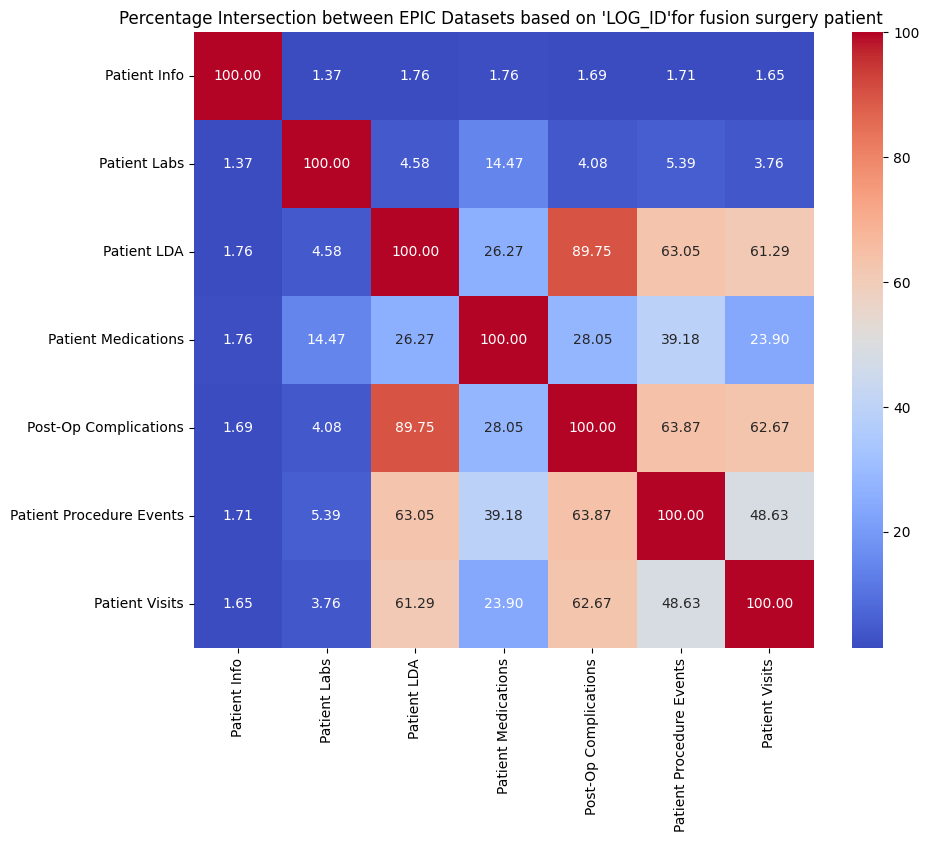

In [13]:
# Create a function to calculate the percentage overlap between two DataFrames
def intersection_percentage(df1, df2, key):
    set1 = set(df1[key])
    set2 = set(df2[key])
    intersection_size = len(set1.intersection(set2))
    total_size = len(set1.union(set2))
    return (intersection_size / total_size) * 100

# Create a matrix to store the percentage intersections
dfs = {
    'Patient Info': combined_records,
    # 'Patient Coding': epic_patient_coding,
    # 'Patient History': epic_patient_history,
    'Patient Labs': epic_patient_labs,
    'Patient LDA': epic_patient_lda,
    'Patient Medications': epic_patient_medications,
    'Post-Op Complications': epic_post_op_complications,
    'Patient Procedure Events': epic_patient_procedure_events,
    'Patient Visits': epic_patient_visits
}

# Assuming 'PID' is the common column across all DataFrames
keys = list(dfs.keys())
intersection_matrix = pd.DataFrame(index=keys, columns=keys)

# Fill the matrix with percentage overlaps
for df1_key in dfs:
    for df2_key in dfs:
        intersection_matrix[df1_key][df2_key] = intersection_percentage(dfs[df1_key], dfs[df2_key], 'LOG_ID')

# Convert to numeric values for plotting
intersection_matrix = intersection_matrix.astype(float)

# Generate the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(intersection_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Percentage Intersection between EPIC Datasets based on 'LOG_ID'for fusion surgery patient ")
plt.show()


### Observation
As shown in the first row of the graph, there are a lot of information missing for fusion surgery patient(only on average 1.5% data across all tables exists in the table) for patient who had scoliosis surgery, which is a big challenge.

## Feature & Label Collection

### Label Selection
since we are predicting post operation complications, I would start by analyzing and cleaning the SMRTDTA_ELEM_VALUE in the post_op_complication table, which provides description to any post operation complications.

In [421]:
epic_post_op_complications

,LOG_ID,MRN,Element_Name,CONTEXT_NAME,Element_abbr,SMRTDTA_ELEM_VALUE
0,b00c588406aae5cc,1a42f0bed60c5598,AN AQI POST-OP COMPLICATIONS,ENCOUNTER,AN Post-op Complications,NaN
1,a16571d21874c0a7,596a6dc60f54a0bb,AN AQI POST-OP COMPLICATIONS,NOTE,AN Post-op Complications,NaN
2,a16571d21874c0a7,596a6dc60f54a0bb,AN AQI POST-OP COMPLICATIONS,NOTE,AN Post-op Complications,NaN
3,1d9ff2d157fa4c86,60e6ea6cf06b58d7,AN AQI POST-OP COMPLICATIONS,ORDER,AN Post-op Complications,NaN
4,2ae43a4a39735956,59c5483e0654e105,AN AQI POST-OP COMPLICATIONS,ENCOUNTER,AN Post-op Complications,Other
...,...,...,...,...,...,...
203940,41e9d0fc85705586,a7b31506e6207021,AN AQI POST-OP COMPLICATIONS,ENCOUNTER,AN Post-op Complications,NaN
203941,c998b4d14118fdf8,3f1772becaaebb81,AN AQI POST-OP COMPLICATIONS,ENCOUNTER,AN Post-op Complications,NaN
203942,689a22b76d123ff6,65c32dd7fd5e35e7,AN AQI POST-OP COMPLICATIONS,ENCOUNTER,AN Post-op Complications,NaN
203943,58a3296cc7491dd2,f7fc111bcf19de88,AN AQI POST-OP COMPLICATIONS,ENCOUNTER,AN Post-op Complications,NaN


In [422]:
# filtered_post_op = epic_post_op_complications[
#     (epic_post_op_complications['LOG_ID'].isin(combined_records['LOG_ID'])) &
#     (epic_post_op_complications['MRN'].isin(combined_records['MRN']))
# ]
filtered_post_op = epic_post_op_complications.merge(
    combined_records[['LOG_ID','MRN']], 
    on=['LOG_ID', 'MRN'],  # Join on both LOG_ID and MRN
    how='right'  # Use left join to keep all rows from final_dataset_with_lda_counts
)


In [423]:
filtered_post_op['Element_abbr'].unique()

array(['AN Post-op Complications', nan, 'Cardiovascular', 'Other',
       'Injury/Infection', 'Airway', 'Neurological', 'Respiratory',
       'Administrative', 'Medication', 'Metabolic'], dtype=object)

In [424]:

filtered_post_op = filtered_post_op.fillna('NO_COMPLICATION')
filtered_post_op = filtered_post_op.drop(columns = ['CONTEXT_NAME','Element_Name','SMRTDTA_ELEM_VALUE'])

In [425]:
filtered_post_op

,LOG_ID,MRN,Element_abbr
0,987faad1df9faadc,c3ce84c4f165f902,AN Post-op Complications
1,987faad1df9faadc,c3ce84c4f165f902,AN Post-op Complications
2,5e489dbc6580221b,0f8af50e7589f7ac,AN Post-op Complications
3,e83c74d87754d599,8cf134ee78c165a6,AN Post-op Complications
4,e83c74d87754d599,8cf134ee78c165a6,AN Post-op Complications
...,...,...,...
2662,0d85bfcd563b48ab,b8bcbdfee198e97f,AN Post-op Complications
2663,c3b0bf319f7d06d5,9b31932cb06c9a3d,AN Post-op Complications
2664,c3b0bf319f7d06d5,9b31932cb06c9a3d,AN Post-op Complications
2665,c755d794568d2736,ff51c972f657bea1,AN Post-op Complications


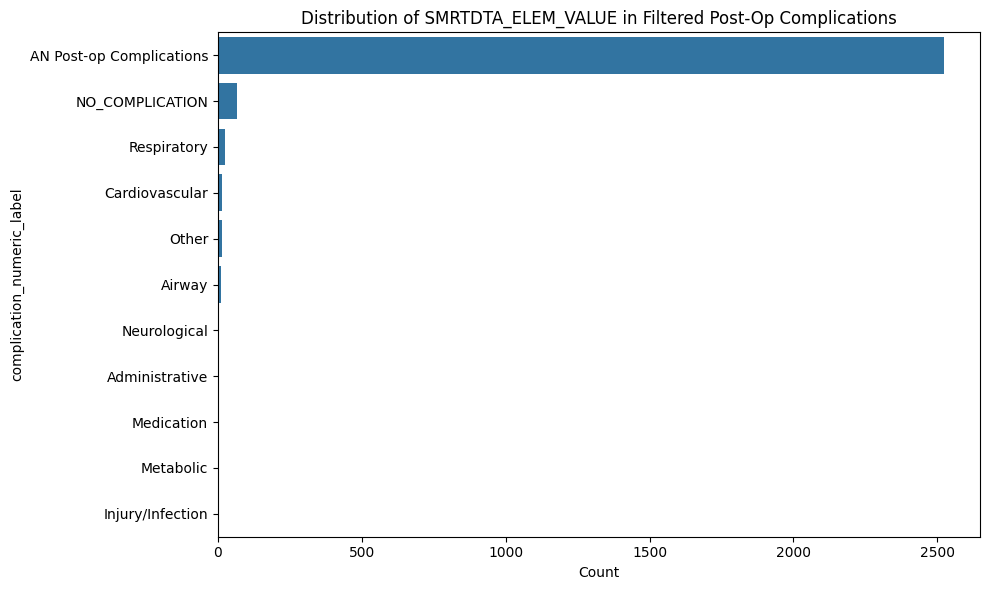

In [426]:

# Plot the value distribution of SMRTDTA_ELEM_VALUE
plt.figure(figsize=(10, 6))
sns.countplot(y='Element_abbr', data=filtered_post_op, order=filtered_post_op['Element_abbr'].value_counts().index)
plt.title('Distribution of SMRTDTA_ELEM_VALUE in Filtered Post-Op Complications')
plt.xlabel('Count')
plt.ylabel('complication_numeric_label')
plt.tight_layout()
plt.show()

### Observation: 
The figure above shows label distribution. Eventhough post surgerical complication is not a direct indictaion of whether the surgery is successful, it is a good way for us to know whether the patient suffers a lot of pain due to the surgery. However, this data trend is bad for a machine learning task, since it is highly unbalanced. Moreover, this labeling method does not take into consideration of patient with multiple complications. Therefore, I relabel the labels to only 0,1, and 2, where 0 is no complication, 1 means 1 complication, and 2 means multiple complications. This is a good scoring scale that allows us to see how successful a surgery went.

In [445]:
# Flag for no complication
filtered_post_op['no_complication_flag'] = filtered_post_op['Element_abbr'] == 'NO_COMPLICATION'

# Step 2: Group by 'LOG_ID' and 'MRN' and count complications
complication_counts = filtered_post_op.groupby(['LOG_ID', 'MRN']).agg(
    complication_count=('Element_abbr', lambda x: (x != 'NO_COMPLICATION').sum()),  # Count complications excluding 'no_complication'
    no_complication_exists=('no_complication_flag', 'any')  # Check if 'no_complication' exists
).reset_index()

# Step 3: Relabel complications as 0, 1, or 2
def label_complications(row):
    if row['complication_count'] == 0 and row['no_complication_exists']:
        return 0  # Only 'no_complication'
    elif row['complication_count'] == 1:
        return 1  # 'no_complication' and one other complication
    else:
        return 2  # 'no_complication' and two or more other complications, or multiple complications

complication_counts['complication_label'] = complication_counts.apply(label_complications, axis=1)

# Step 4: Merge back with the original DataFrame
filtered_post_op = filtered_post_op.merge(complication_counts[['LOG_ID', 'MRN', 'complication_label']], 
                                          on=['LOG_ID', 'MRN'], 
                                          how='left')

# Drop the temporary 'no_complication_flag' column
filtered_post_op = filtered_post_op.drop(columns=['no_complication_flag'], errors='ignore')

# Display the resulting DataFrame
filtered_post_op.head()


filtered_post_op = filtered_post_op.drop(columns=['complication_label_x', 'complication_label_y'], errors='ignore')

In [446]:
filtered_post_op

,LOG_ID,MRN,Element_abbr,complication_label
0,987faad1df9faadc,c3ce84c4f165f902,AN Post-op Complications,2
1,987faad1df9faadc,c3ce84c4f165f902,AN Post-op Complications,2
2,5e489dbc6580221b,0f8af50e7589f7ac,AN Post-op Complications,2
3,e83c74d87754d599,8cf134ee78c165a6,AN Post-op Complications,2
4,e83c74d87754d599,8cf134ee78c165a6,AN Post-op Complications,2
...,...,...,...,...
2662,0d85bfcd563b48ab,b8bcbdfee198e97f,AN Post-op Complications,2
2663,c3b0bf319f7d06d5,9b31932cb06c9a3d,AN Post-op Complications,2
2664,c3b0bf319f7d06d5,9b31932cb06c9a3d,AN Post-op Complications,2
2665,c755d794568d2736,ff51c972f657bea1,AN Post-op Complications,1


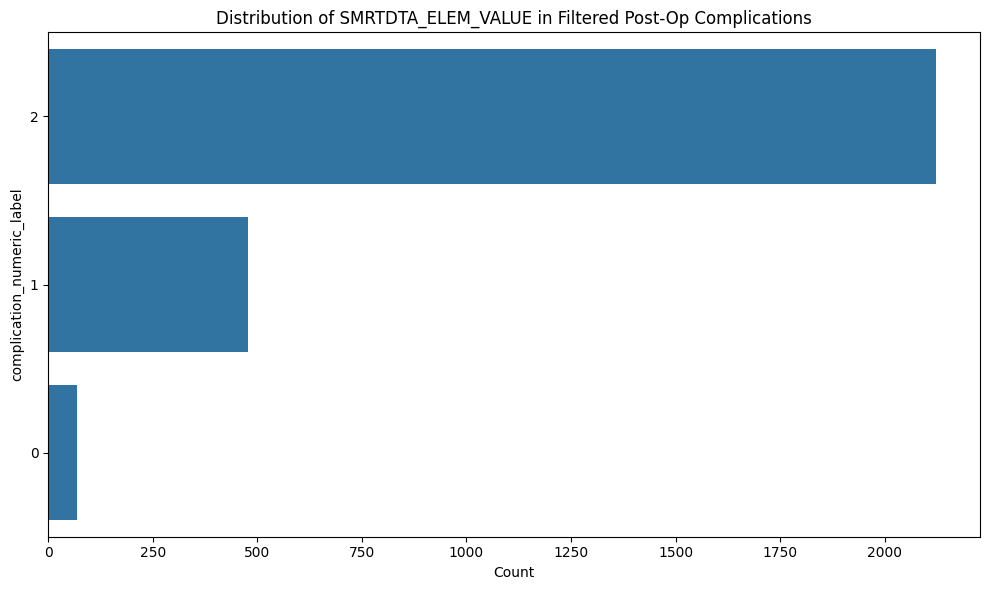

In [447]:

# Plot the value distribution of SMRTDTA_ELEM_VALUE
plt.figure(figsize=(10, 6))
sns.countplot(y='complication_label', data=filtered_post_op, order=filtered_post_op['complication_label'].value_counts().index)
plt.title('Distribution of SMRTDTA_ELEM_VALUE in Filtered Post-Op Complications')
plt.xlabel('Count')
plt.ylabel('complication_numeric_label')
plt.tight_layout()
plt.show()

In [448]:
filtered_post_op.to_csv("label.csv")

## Constructing features
Now my data will be in unit of LOG_ID, MRI pair in combined_records, and my label would be complication label in filtered_post_op table. To construct the feature set, I will start with the selected patient_info table as a base, joining or aggregating data from other tables onto this.
#### Encoding Feature
During the feature construction process, the main problem that I would think about is how to encode all information into one row of data. For example, in my feature setting, a piece of data is defined as a LOG_ID, MRN pair. However, for each LOG_ID, MRN pair, there could be multiple rows of medication information. Therefore in this case, using one row to represent all medications that a LOG_ID, MRN pair record is related to is very hard. In this case, I utilized a technique called one hot encoding. Basciallt, instead of representing different medication as a different row, I would add n features that corresponse to n unique medications, and for each record, I would put a data representing total time that the patient take the particular medication. 

#### Cleaning Data that are Unaccessable Before Surgery
To make sure that the prediction task makes sense, I would also have to remove data related to surgery, and any data that's recorded after surgery. Since in a real world use, those data wouldn't be provided to the model to make decisions with.

#### Cleaning Initial Patient Info Dataset


In [530]:
# Start with combined_records as the base
final_dataset = combined_records.copy()

In [531]:
final_dataset.columns

Index(['LOG_ID', 'MRN', 'DISCH_DISP_C', 'DISCH_DISP', 'HOSP_ADMSN_TIME',
       'HOSP_DISCH_TIME', 'LOS', 'ICU_ADMIN_FLAG', 'SURGERY_DATE',
       'BIRTH_DATE', 'HEIGHT', 'WEIGHT', 'SEX', 'PRIMARY_ANES_TYPE_NM',
       'ASA_RATING_C', 'ASA_RATING', 'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM',
       'PRIMARY_PROCEDURE_NM', 'IN_OR_DTTM', 'OUT_OR_DTTM',
       'AN_START_DATETIME', 'AN_STOP_DATETIME', 'mrn', 'diagnosis_code',
       'dx_name'],
      dtype='object')

In [532]:
final_dataset = final_dataset.drop(columns=['LOS','mrn','diagnosis_code', 'dx_name','OUT_OR_DTTM', 'IN_OR_DTTM','AN_STOP_DATETIME','AN_START_DATETIME','HOSP_DISCH_TIME', 'ICU_ADMIN_FLAG']).drop_duplicates()

In [533]:
final_dataset.columns

Index(['LOG_ID', 'MRN', 'DISCH_DISP_C', 'DISCH_DISP', 'HOSP_ADMSN_TIME',
       'SURGERY_DATE', 'BIRTH_DATE', 'HEIGHT', 'WEIGHT', 'SEX',
       'PRIMARY_ANES_TYPE_NM', 'ASA_RATING_C', 'ASA_RATING',
       'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM', 'PRIMARY_PROCEDURE_NM'],
      dtype='object')

#### merging lab data using one hot encoding:
For each type of labe report, a value, a abnormal flag, and a collectin time is added to the feature.

In [534]:
epic_patient_labs.columns

Index(['LOG_ID', 'MRN', 'ENC_TYPE_NM', 'Lab Code', 'Lab Name',
       'Observation Value', 'Abnormal Flag', 'Collection Datetime'],
      dtype='object')

In [ ]:
epic_patient_labs = epic_patient_labs.drop(columns = ['Reference Range','Measurement Units']).drop_duplicates()

In [536]:
# ONE HOT ECODING for lab data

# Pivot table to create separate columns for 'Observation Value', 'Abnormal Flag', and 'Collection Datetime'
pivoted_labs_value = epic_patient_labs.pivot_table(index=['LOG_ID', 'MRN'], 
                                                   columns='Lab Name', 
                                                   values='Observation Value', 
                                                   aggfunc='first')

pivoted_labs_flag = epic_patient_labs.pivot_table(index=['LOG_ID', 'MRN'], 
                                                  columns='Lab Name', 
                                                  values='Abnormal Flag', 
                                                  aggfunc='first')

pivoted_labs_time = epic_patient_labs.pivot_table(index=['LOG_ID', 'MRN'], 
                                                  columns='Lab Name', 
                                                  values='Collection Datetime', 
                                                  aggfunc='first')

# Rename the columns to follow the format: 'labname_value', 'labname_abnormal', 'labname_time'
pivoted_labs_value.columns = [f'{col}_value' for col in pivoted_labs_value.columns]
pivoted_labs_flag.columns = [f'{col}_abnormal' for col in pivoted_labs_flag.columns]
pivoted_labs_time.columns = [f'{col}_time' for col in pivoted_labs_time.columns]

# Concatenate the pivoted tables along the columns (axis=1)
pivoted_labs_combined = pd.concat([pivoted_labs_value, pivoted_labs_flag, pivoted_labs_time], axis=1)

# Reset the index to join later with the final dataset
pivoted_labs_combined.reset_index(inplace=True)

# Join the pivoted lab data with your main dataset
final_dataset_with_labs = final_dataset.merge(pivoted_labs_combined, on=['LOG_ID', 'MRN'], how='left')

In [537]:

final_dataset_with_labs = final_dataset_with_labs.drop_duplicates()

In [538]:
final_dataset_with_labs.head(1)

,LOG_ID,MRN,DISCH_DISP_C,DISCH_DISP,HOSP_ADMSN_TIME,SURGERY_DATE,BIRTH_DATE,HEIGHT,WEIGHT,SEX,...,oxyCODONE_time,pH_time,pH^^adjusted to patient's actual temperature_time,"t(9;22)(q34.1;q11)(ABL1,BCR) b2a2+b3a2 fusion transcript/control transcript (International Scale)_time","t(9;22)(q34.1;q11)(ABL1,BCR) fusion transcript_time",traMADol_time,von Willebrand factor Ag actual/Normal_time,von Willebrand factor cleaving protease actual/normal_time,von Willebrand factor multimers_time,von Willebrand factor.ristocetin cofactor activity actual/Normal_time
0,987faad1df9faadc,c3ce84c4f165f902,100.0,Rehab Facility (this hospital),1/11/20 6:07,1/13/20 0:00,80,5' 3,3280.44,Female,...,NaN,2020-01-13 11:51:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### merging medication info using one hot encoding
different medication is added as different features, value indicating total time the patient took the medication

In [539]:
epic_patient_medications.columns

Index(['ENC_TYPE_C', 'ENC_TYPE_NM', 'LOG_ID', 'MRN', 'ORDERING_DATE',
       'ORDER_CLASS_NM', 'MEDICATION_ID', 'DISPLAY_NAME', 'MEDICATION_NM',
       'START_DATE', 'END_DATE', 'ORDER_STATUS_NM', 'RECORD_TYPE',
       'MAR_ACTION_NM', 'MED_ACTION_TIME', 'ADMIN_SIG', 'DOSE_UNIT_NM',
       'MED_ROUTE_NM', 'duration'],
      dtype='object')

In [540]:
import pandas as pd

# First, create a duration column where it's the difference between END_DATE and START_DATE
epic_patient_medications['START_DATE'] = pd.to_datetime(epic_patient_medications['START_DATE'], errors='coerce')
epic_patient_medications['END_DATE'] = pd.to_datetime(epic_patient_medications['END_DATE'], errors='coerce')

# Calculate duration in days
epic_patient_medications['duration'] = (epic_patient_medications['END_DATE'] - epic_patient_medications['START_DATE']).dt.days

# Now pivot the data so that each medication has its own column
pivoted_medications = epic_patient_medications.pivot_table(
    index=['LOG_ID', 'MRN'],  # Use LOG_ID and MRN as the index
    columns='MEDICATION_NM',  # Pivot based on medication name
    values='duration',  # The value for each medication is the duration
    aggfunc='sum'  # If there are multiple records, sum the durations
).fillna(0)  # Fill NaN values with 0

# Reset the index to flatten the DataFrame
pivoted_medications = pivoted_medications.reset_index()



In [541]:
# Perform the merge/join on LOG_ID and MRN
final_dataset_with_medications = final_dataset_with_labs.merge(
    pivoted_medications, 
    on=['LOG_ID', 'MRN'],  # Join on both LOG_ID and MRN
    how='left'  # Use left join to keep all rows from final_dataset_with_lda_counts
)

In [542]:
final_dataset_with_medications.columns

Index(['LOG_ID', 'MRN', 'DISCH_DISP_C', 'DISCH_DISP', 'HOSP_ADMSN_TIME',
       'SURGERY_DATE', 'BIRTH_DATE', 'HEIGHT', 'WEIGHT', 'SEX',
       ...
       'sodium bicarbonate 8.4% injection  - ADS OVERRIDE',
       'sodium chloride (HYPERTONIC SALINE) 3 % infusion  - ADS OVERRIDE',
       'sodium chloride 0.9 % flush  - ADS OVERRIDE',
       'sodium chloride 4 mEq/mL 23.4% (CONCENTRATED) injection  - ADS OVERRIDE',
       'sodium chloride 4 mEq/mL oral solution  - ADS OVERRIDE',
       'sodium citrate-citric acid (BICITRA) 500-334 MG/5ML solution  - ADS OVERRIDE',
       'sterile water (PF) injection  - ADS OVERRIDE',
       'succinylcholine (ANECTINE) 20 MG/ML injection  - ADS OVERRIDE',
       'terbutaline (BRETHINE) 1 MG/ML injection  - ADS OVERRIDE',
       'vecuronium (NORCURON) 10 MG injection  - ADS OVERRIDE'],
      dtype='object', length=3769)

#### merging event data with one hot encoding
Different event type is added as separate features, sum of the number of time the event happens is filled as values

In [ ]:
epic_patient_procedure_events = epic_patient_procedure_events.drop(columns = ['NOTE_TEXT'])

In [544]:
epic_patient_procedure_events.columns

Index(['LOG_ID', 'MRN', 'EVENT_DISPLAY_NAME', 'EVENT_TIME'], dtype='object')

In [545]:

# Step 1: Merge event data with main dataset
final_dataset_with_event = final_dataset_with_medications.merge(
    epic_patient_procedure_events[['LOG_ID', 'MRN', 'EVENT_DISPLAY_NAME', 'EVENT_TIME']],
    on=['LOG_ID', 'MRN'], 
    how='left'
)

# Step 2: Convert 'EVENT_TIME' to seconds (numeric) for summing
final_dataset_with_event['EVENT_TIME'] = pd.to_timedelta(final_dataset_with_event['EVENT_TIME'], errors='coerce').dt.total_seconds()

# Step 3: Group by 'LOG_ID', 'MRN', and 'EVENT_DISPLAY_NAME' and sum event times
grouped_events = final_dataset_with_event.groupby(['LOG_ID', 'MRN', 'EVENT_DISPLAY_NAME']).agg({'EVENT_TIME': 'sum'}).reset_index()

# Step 4: Pivot the data to one-hot encode the event types, with summed times as values
pivoted_events = grouped_events.pivot_table(
    index=['LOG_ID', 'MRN'], 
    columns='EVENT_DISPLAY_NAME', 
    values='EVENT_TIME', 
    fill_value=0
).reset_index()

# Step 5: Rename columns to make them more clear
pivoted_events.columns.name = None  # Remove the column grouping name
pivoted_events.columns = ['LOG_ID', 'MRN'] + [f"{col}_time" for col in pivoted_events.columns if col not in ['LOG_ID', 'MRN']]

# Step 6: Merge the one-hot encoded event times back to the main dataset
final_dataset_with_event_encoded = final_dataset_with_medications.merge(
    pivoted_events, 
    on=['LOG_ID', 'MRN'], 
    how='left'
)



In [546]:
final_dataset_with_event_encoded.to_csv("final_feature_dataset.csv")

In [547]:
# filtered_post_op=pd.read_csv("label.csv")

### Observation
Due to one hot encoding, it is clear that the number of rows of data did not change, while the feature increases significantly. This is expected, since multiple features related to every unique medication, every unique events, every unique lab tests are added to the feature set. This is also expected to improve prediction result, since having more information allows model to learn more about the patient, therefore making better decision

## Data Cleaning
In this step, I will deal with the non numeric columns and NaN values. More specifically, i will convert all categorical columns to a numeric encoding. And for origionally numeric value with NaN, I would replace them as a sum of the other values in the column(e.g. lab results). For later converted columns, their NaN value will be represented as NA, then converting to a numeric encoding.

In [548]:
feature_label = final_dataset_with_event_encoded.merge(
    filtered_post_op[['LOG_ID','MRN','complication_label']], 
    on=['LOG_ID', 'MRN'],  # Join on both LOG_ID and MRN
    how='inner'  # Use left join to keep all rows from final_dataset_with_lda_counts
)
feature_label = feature_label.drop_duplicates()

#### fill empty values with average

In [549]:
# Check the data types of the columns
print("Data types of columns in feature_label:")
print(feature_label.dtypes)

# For numerical columns, we convert columns to numeric where possible and handle missing values
numerical_cols = feature_label.select_dtypes(include=['float64', 'int64']).columns

# Ensure non-numerical values are converted to NaN for numerical columns
for col in numerical_cols:
    feature_label[col] = pd.to_numeric(feature_label[col], errors='coerce')  # Invalid values are converted to NaN

# Now, fill NaN with the mean for these numerical columns
feature_label[numerical_cols] = feature_label[numerical_cols].apply(lambda col: col.fillna(col.mean()))

# For categorical columns, we fill NaN with the string 'NA'
categorical_cols = feature_label.select_dtypes(include=['object']).columns

# Fill NaN in categorical columns with 'NA'
feature_label[categorical_cols] = feature_label[categorical_cols].fillna('NA')

# Now, drop any duplicates in the dataset
feature_label = feature_label.drop_duplicates()



Data types of columns in feature_label:
LOG_ID                                                       object
MRN                                                          object
DISCH_DISP_C                                                float64
DISCH_DISP                                                   object
HOSP_ADMSN_TIME                                              object
                                                             ...   
Surgeon on Cuff_time                                        float64
Transported to PACU/ICU with O2, vital signs stable_time    float64
Two Anti-Emetics Administered_time                          float64
Visit Signed_time                                           float64
complication_label                                            int64
Length: 3801, dtype: object


In [550]:
# For columns with object type (string), try to convert to integers if possible.
for col in feature_label.select_dtypes(include=['object']).columns:
    # Try to convert directly to integers if they represent numerical values (e.g., string-formatted numbers)
    try:
        feature_label[col] = pd.to_numeric(feature_label[col])
    except ValueError:
        # If the column has non-numeric data, apply label encoding for categorical data
        label_encoder = LabelEncoder()
        feature_label[col] = label_encoder.fit_transform(feature_label[col].astype(str))

# After conversion, check for any remaining columns with 'object' type that couldn't be converted
print("Data types after conversion:")
print(feature_label.dtypes)


Data types after conversion:
LOG_ID                                                        int64
MRN                                                           int64
DISCH_DISP_C                                                float64
DISCH_DISP                                                    int64
HOSP_ADMSN_TIME                                               int64
                                                             ...   
Surgeon on Cuff_time                                        float64
Transported to PACU/ICU with O2, vital signs stable_time    float64
Two Anti-Emetics Administered_time                          float64
Visit Signed_time                                           float64
complication_label                                            int64
Length: 3801, dtype: object


In [551]:
# Step 1: Identify all columns with datetime or timedelta types
datetime_columns = feature_label.select_dtypes(include=['datetime64[ns]']).columns
timedelta_columns = feature_label.select_dtypes(include=['timedelta64[ns]']).columns

# Step 2: Convert datetime columns (optional)
# If necessary, you can extract useful information from datetime columns, like the date, hour, etc.
# Here we just keep them as datetime, no conversion needed unless specific operation is required.

# Step 3: Convert timedelta columns to total seconds
for col in timedelta_columns:
    feature_label[col] = feature_label[col].dt.total_seconds()  # Convert timedelta to total seconds

# Step 4: Verify the conversion
print("Datetime Columns:", datetime_columns)
print("Timedelta Columns (converted to seconds):", timedelta_columns)


Datetime Columns: Index([], dtype='object')
Timedelta Columns (converted to seconds): Index([], dtype='object')


## Model Training and Result Analysis

In this step, I will train 2 models to compare the performance of a naive ensemble tree algorithm, and random forest with two settings.

In [599]:
final_dataset = feature_label.copy()

In [553]:
final_dataset.to_csv("final_dataset.csv")

In [600]:
# Assuming your dataset is in 'final_dataset'
X = final_dataset.drop(columns=['LOG_ID', 'MRN', 'complication_label'])  # Drop identifiers and labels
y = final_dataset['complication_label']  # Target variable

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [601]:
pd.DataFrame(y).to_csv('testset.csv')

### Train a Single Decision Tree (C4.5-like):
I use the DecisionTreeClassifier from scikit-learn for testing single tree structure(https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html), which is based on the CART algorithm, very similar to C4.5.

In [602]:
# Train a single decision tree
tree_model = DecisionTreeClassifier(random_state=42)
start_time = time.time()
tree_model.fit(X_train, y_train)
single_tree_training_time = time.time() - start_time

# Predict and evaluate
y_pred_tree = tree_model.predict(X_test)
single_tree_accuracy = accuracy_score(y_test, y_pred_tree)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
print(f"Decision Tree Test Accuracy: {single_tree_accuracy}")
print(f"Decision Tree Training Time: {single_tree_training_time}")


Decision Tree Test Accuracy: 0.5151515151515151
Decision Tree Training Time: 0.10275459289550781


### Train a Random Forest:
Next, in this experient, I will experiment using random forest algroithm(https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html), investigating how the number of trees in the Random Forest affects the test accuracy. Random forests are ensemble models, which combine multiple decision trees to make more robust predictions. So as the number of trees increase, the prediction score is expected to increase. However, having too many trees could potentially cause overfitting, which shows the importance of trail and error to search for the most optimal setting for # trees.

In [ ]:
# Range of number of trees to test
n_estimators_range = [1, 5, 10, 25, 50, 100, 500, 1100, 2000, 5000, 7000, 10000, 15000, 20000]
accuracy_scores = []
training_times = []
precision_scores = []
recall_scores = []

for n_estimators in n_estimators_range:
    # Track the start time
    start_time = time.time()
    
    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Record the training time
    training_time = time.time() - start_time
    training_times.append(training_time)
    
    # Predict and evaluate accuracy
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    # Compute precision, recall, and f1-score using classification_report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    precision_scores.append(precision)
    recall_scores.append(recall)

## Analysis on Random Forest Result
###  RF Accuracy Graph Analysis
The test accuracy of the Random Forest model shows significant improvement with an increasing number of trees up to a certain point. Starting with a single tree, the model achieves an accuracy of 52%. As we increase the number of trees to 25, the accuracy significantly increases to around 60%, then the trend stablizes and steadly increases. The maximum accuracy observed in the experiment is around 61% when the forest consists of 1100 trees. Beyond this point, there is no further improvement in accuracy, and the performance tends to faltten and drop, indicates that beyond a certain number of trees, adding more trees does not result in better accuracy due to overfitting.

### Analysis on Precison and Recall
Evaluating precision and recall alongside accuracy provides deeper insights into how well the model handles the different classes in a multi-class prediction setting. Given that our dataset is imbalanced across the three classes (0: no complication, 1: one complication, 2: multiple complications), focusing on precision and recall helps reveal potential weaknesses in the model's ability to correctly identify the most critical cases.

#### Precision and Recall under Project Context
Recall measures the model's ability to correctly identify all true positive cases. A higher recall means the model is more inclusive in its positive predictions, ensuring that most or all patients who experience complications are identified. However, this inclusiveness comes at the cost of a higher false positive rate, which may result in over-predicting complications for patients who may not have them.

Precision, on the other hand, reflects the proportion of positive predictions that are correct. A higher precision means that when the model predicts a patient will have complications, it is highly likely to be correct. In this context, precision is crucial when the consequences of incorrectly predicting a bad outcome (false positives) are less severe than missing a potential complication (false negatives).

In our specific task of predicting surgery outcomes, higher precision is more important than higher recall. This is because we want to minimize the risk of falsely predicting good outcomes when complications could happen. Misidentifying patients with potential complications as having no or fewer complications could lead to inadequate post-surgery care. 

#### Analysis on Precision and recall scores from the figure below

From the observed trend, it’s clear that precision is consistently lower than recall by around 1%, which indicates that the model tends to over-predict cases with fewer complications or no complications (i.e., it tends to incorrectly classify patients who may have multiple complications as having fewer or none). This is not ideal, as it means that while the model is better at capturing most patients with complications (high recall), it is not as effective at making precise predictions about which patients will have complications. This could lead to potential under-treatment of patients with severe complications, which is critical to avoid in a medical context. 

Whats notable is though the difference is consistent, it is not a very big difference, therefore to improve the model accuracy overall is still the next major challenge to overcome.


In [619]:
# Result Table
data = {
    'n_estimators': n_estimators_range,
    'accuracy': accuracy_scores,
    'training_time': training_times,
    'precision': precision_scores,
    'recall': recall_scores
}

# Convert the dictionary to a pandas DataFrame
df_results = pd.DataFrame(data)
df_results

,n_estimators,accuracy,training_time,precision,recall
0,1,0.519481,0.070054,0.519316,0.519481
1,5,0.593074,0.096372,0.583723,0.593074
2,10,0.584416,0.134870,0.573718,0.584416
3,25,0.593074,0.252927,0.555430,0.593074
4,50,0.593074,0.451349,0.611630,0.593074
5,100,0.601732,0.857644,0.620412,0.601732
6,500,0.601732,4.060218,0.619619,0.601732
7,1100,0.610390,8.894529,0.628155,0.610390
8,2000,0.606061,16.091570,0.623763,0.606061
9,5000,0.601732,40.137632,0.620200,0.601732


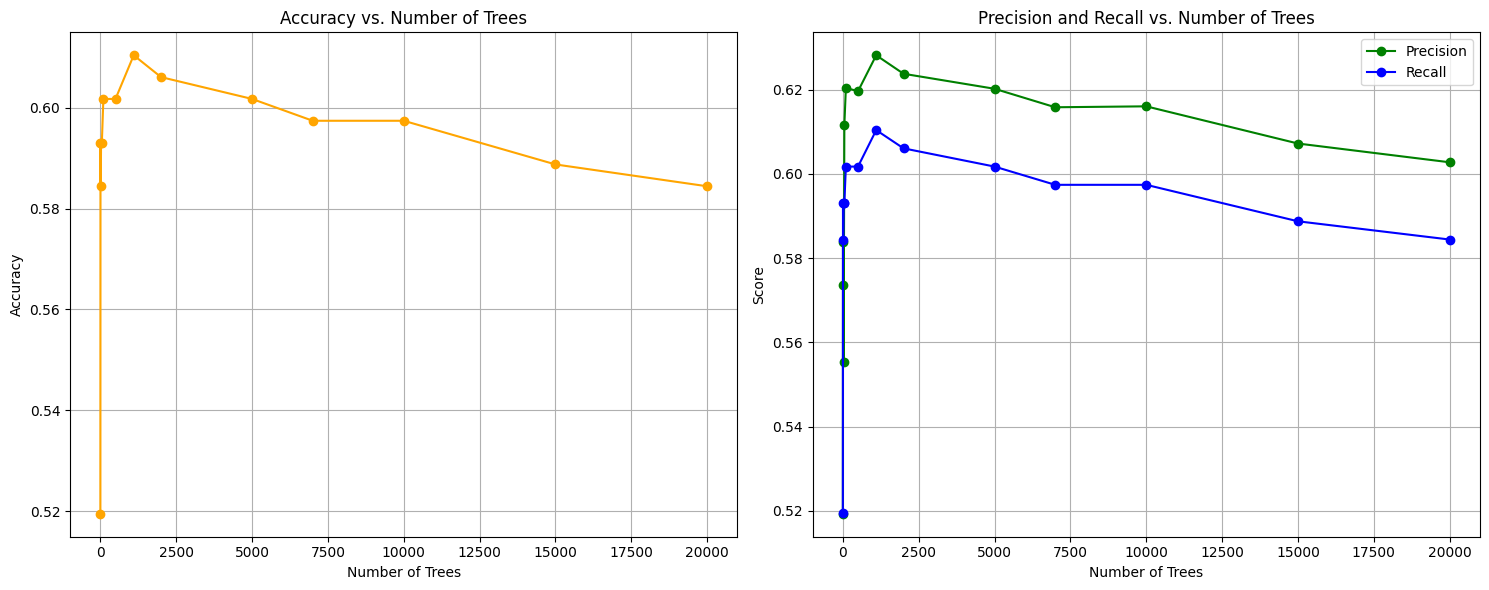

In [611]:
# Create subplots with 1 row and 2 columns (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Accuracy on the first subplot
axes[0].plot(n_estimators_range, accuracy_scores, marker='o', label="Accuracy", color='orange')
axes[0].set_title('Accuracy vs. Number of Trees')
axes[0].set_xlabel('Number of Trees')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)

# Plot Precision and Recall on the second subplot
axes[1].plot(n_estimators_range, precision_scores, marker='o', label="Precision", color='green')
axes[1].plot(n_estimators_range, recall_scores, marker='o', label="Recall", color='blue')
axes[1].set_title('Precision and Recall vs. Number of Trees')
axes[1].set_xlabel('Number of Trees')
axes[1].set_ylabel('Score')
axes[1].legend()  # Add legend for Precision and Recall
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()



### Random Forest Training Time Graph Analysis
As shown in the figure below, The training time follows a near linear trend as the number of trees increases. The time starts at around 0.6 seconds for 1 tree and increases proportionally, reaching about 2 seconds for 400 trees and 30 seconds for 5000 trees. This linear relationship between the number of trees and training time is expected because training additional trees adds more computational work. This steady increase highlights the trade-off between model complexity and computational efficiency. If computational resources are limited, training time might become a more significant factor than accuracy, particularly when additional trees offer diminishing returns in performance.

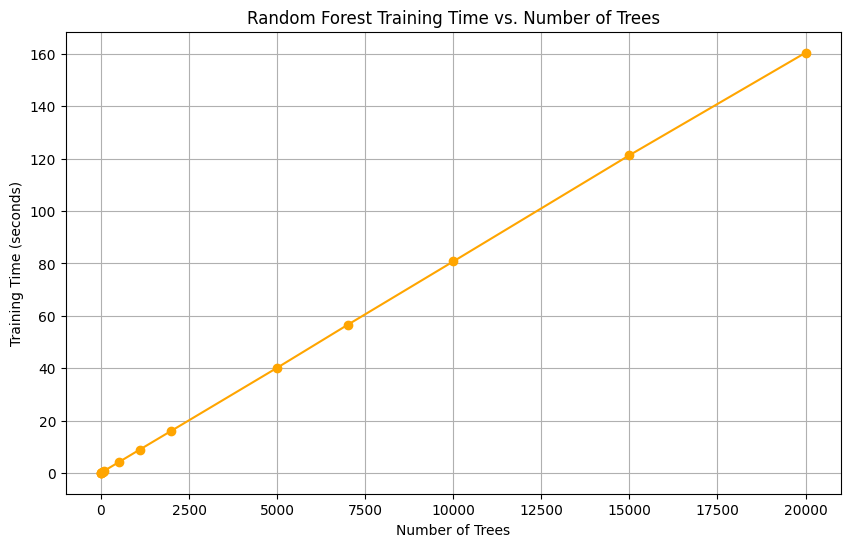

In [607]:
# Plotting Training Time vs. Number of Trees
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, training_times, marker='o', color='orange', label="Training Time")
plt.title('Random Forest Training Time vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.show()


### RF Track top 10 best performing trees
I tracked the top 10 and bottom 10 performing trees in RF with 1100 trees setting, which is the setting that produced top result in last section. According to the result and the graph below, we can observe that the top 10 decision trees in the Random Forest model achieve accuracies around 60%, which is significantly higher than the bottom 10 decision trees, whose accuracies are around 40%. This indicates that there is a notable variance in the performance of individual trees within the ensemble. The overall RF achieves an accuracy of around 60%, which is close to the accuracy of the top 10 trees. This shows that the ensemble benefits from combining both strong and weak trees, since the model’s overall performance remains close to the top 10 performing trees.

In [608]:
# Train Random Forest model with 1100 trees, the top performance moel
rf_model = RandomForestClassifier(n_estimators=1100, random_state=42)
rf_model.fit(X_train, y_train)

# List to store accuracy of individual trees
individual_tree_accuracies = []

# Get predictions from each tree and calculate accuracy
for i, tree in enumerate(rf_model.estimators_):
    # Predict using individual decision tree
    y_pred_tree = tree.predict(X_test)
    
    # Calculate accuracy for this tree
    accuracy = accuracy_score(y_test, y_pred_tree)
    individual_tree_accuracies.append(accuracy)

# Convert list to numpy array for easy sorting
individual_tree_accuracies = np.array(individual_tree_accuracies)

# Find indices of top 10 and bottom 10 accuracies
top_10_indices = np.argsort(individual_tree_accuracies)[-10:]  # Top 10
bottom_10_indices = np.argsort(individual_tree_accuracies)[:10]  # Bottom 10

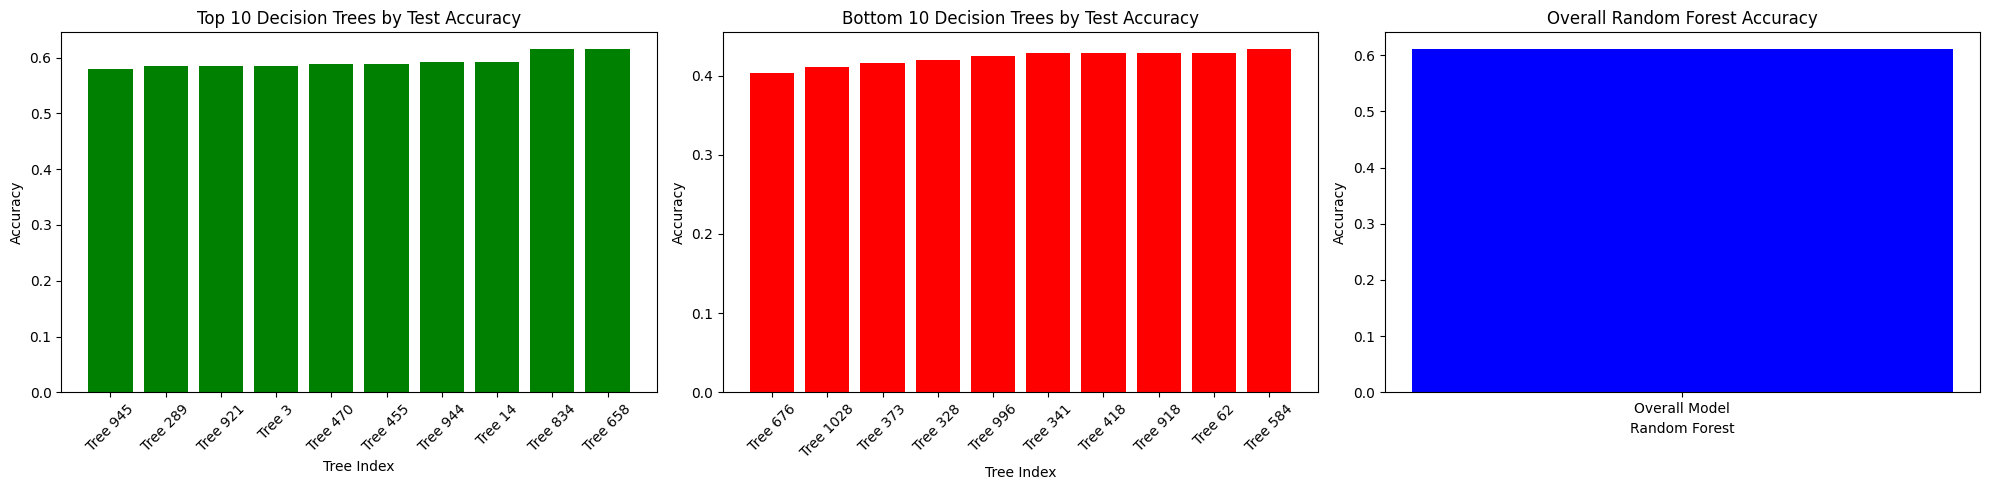


Top 10 Trees with Highest Accuracy:
Tree 945: Test Accuracy = 0.5800865800865801
Tree 289: Test Accuracy = 0.5844155844155844
Tree 921: Test Accuracy = 0.5844155844155844
Tree 3: Test Accuracy = 0.5844155844155844
Tree 470: Test Accuracy = 0.5887445887445888
Tree 455: Test Accuracy = 0.5887445887445888
Tree 944: Test Accuracy = 0.5930735930735931
Tree 14: Test Accuracy = 0.5930735930735931
Tree 834: Test Accuracy = 0.6147186147186147
Tree 658: Test Accuracy = 0.6147186147186147

Bottom 10 Trees with Lowest Accuracy:
Tree 676: Test Accuracy = 0.4025974025974026
Tree 1028: Test Accuracy = 0.41125541125541126
Tree 373: Test Accuracy = 0.4155844155844156
Tree 328: Test Accuracy = 0.4199134199134199
Tree 996: Test Accuracy = 0.42424242424242425
Tree 341: Test Accuracy = 0.42857142857142855
Tree 418: Test Accuracy = 0.42857142857142855
Tree 918: Test Accuracy = 0.42857142857142855
Tree 62: Test Accuracy = 0.42857142857142855
Tree 584: Test Accuracy = 0.4329004329004329


In [609]:
# Calculate overall Random Forest accuracy
overall_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

# Create subplots with 1 row and 3 columns (side by side with overall accuracy on the right)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot Top 10 Trees on the first subplot
axes[0].bar(range(1, 11), individual_tree_accuracies[top_10_indices], color='green')
axes[0].set_title('Top 10 Decision Trees by Test Accuracy')
axes[0].set_xlabel('Tree Index')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(1, 11))
axes[0].set_xticklabels([f'Tree {i+1}' for i in top_10_indices], rotation=45)

# Plot Bottom 10 Trees on the second subplot
axes[1].bar(range(1, 11), individual_tree_accuracies[bottom_10_indices], color='red')
axes[1].set_title('Bottom 10 Decision Trees by Test Accuracy')
axes[1].set_xlabel('Tree Index')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(range(1, 11))
axes[1].set_xticklabels([f'Tree {i+1}' for i in bottom_10_indices], rotation=45)

# Plot Overall Random Forest Accuracy on the third subplot
axes[2].bar([1], [overall_accuracy], color='blue')
axes[2].set_title('Overall Random Forest Accuracy')
axes[2].set_xlabel('Random Forest')
axes[2].set_ylabel('Accuracy')
axes[2].set_xticks([1])
axes[2].set_xticklabels(['Overall Model'])

# Adjust layout
plt.tight_layout()
plt.show()

# Show top 10 trees with highest accuracy
print("\nTop 10 Trees with Highest Accuracy:")
for i in top_10_indices:
    print(f"Tree {i+1}: Test Accuracy = {individual_tree_accuracies[i]}")

# Show bottom 10 trees with lowest accuracy
print("\nBottom 10 Trees with Lowest Accuracy:")
for i in bottom_10_indices:
    print(f"Tree {i+1}: Test Accuracy = {individual_tree_accuracies[i]}")


## Comparing Decision Tree and Random Forest

### Comparing Accuracy and Runtime
The graphs comparing the Decision Tree and Random Forest (with 500 trees) highlight a clear trade-off between accuracy and training time. The Random Forest significantly outperforms the Decision Tree in terms of accuracy, achieving 0.6 compared to the Decision Tree's 0.5. This demonstrates the strength of ensemble methods, as Random Forest can reduce overfitting and better capture patterns in the data by averaging the results of multiple decision trees. However, this accuracy boost comes at a cost: the training time for Random Forest is much higher, at around 2 seconds, compared to the Decision Tree's 0.04 seconds. This increase in training time is expected, as Random Forest involves training multiple trees, but the substantial improvement in performance justifies the additional computational cost. In this context, where the surgery outcome prediction is crutial compare to the training time, Random Forest is clearly the superior model.

### Comparing Feature Importance
The graph on the second cell below shows feature impotrance in a single tree model and Random Forest model. 

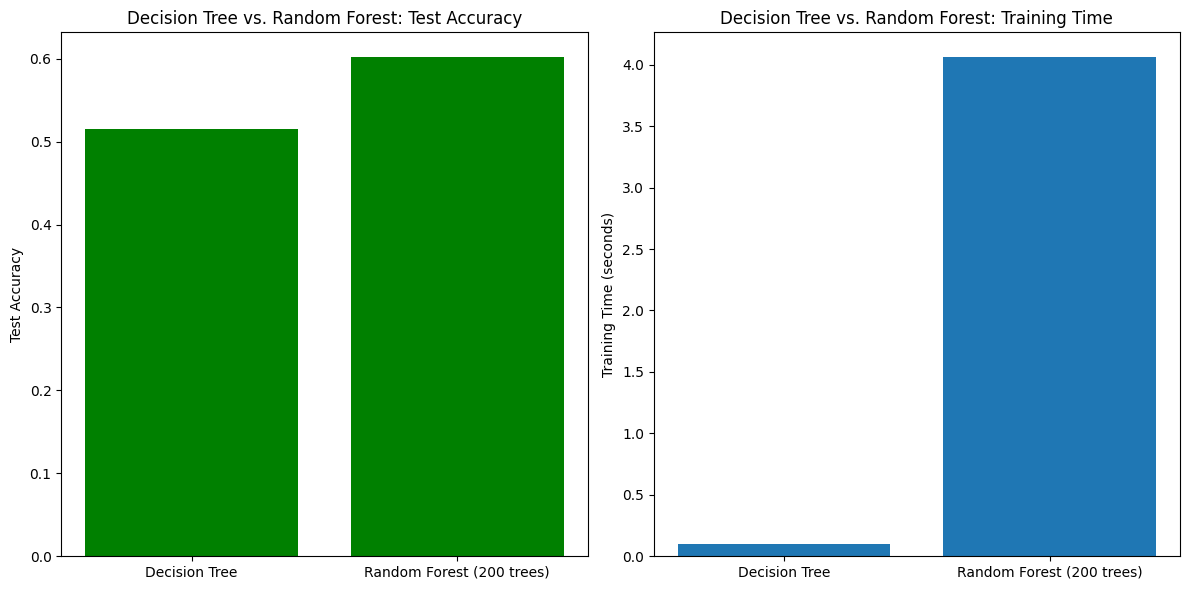

In [615]:
# Best Random Forest results (for 200 trees, since index 8 represents 200 trees in the data)
rf_accuracy_trees = accuracy_scores[6]  # Random Forest accuracy with 200 trees
rf_training_time_trees = training_times[6]  # Random Forest training time with 200 trees

# Create a comparison for Accuracy
models = ['Decision Tree', 'Random Forest (200 trees)']
accuracy_scores_to_plot = [single_tree_accuracy, rf_accuracy_trees]
training_times_to_plot = [single_tree_training_time, rf_training_time_trees]

# Plotting the Accuracy Comparison
plt.figure(figsize=(12, 6))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.bar(models, accuracy_scores_to_plot,color='green')
plt.title('Decision Tree vs. Random Forest: Test Accuracy')
plt.ylabel('Test Accuracy')

# Plot for Training Time
plt.subplot(1, 2, 2)
plt.bar(models, training_times_to_plot)
plt.title('Decision Tree vs. Random Forest: Training Time')
plt.ylabel('Training Time (seconds)')

# Show both plots
plt.tight_layout()
plt.show()


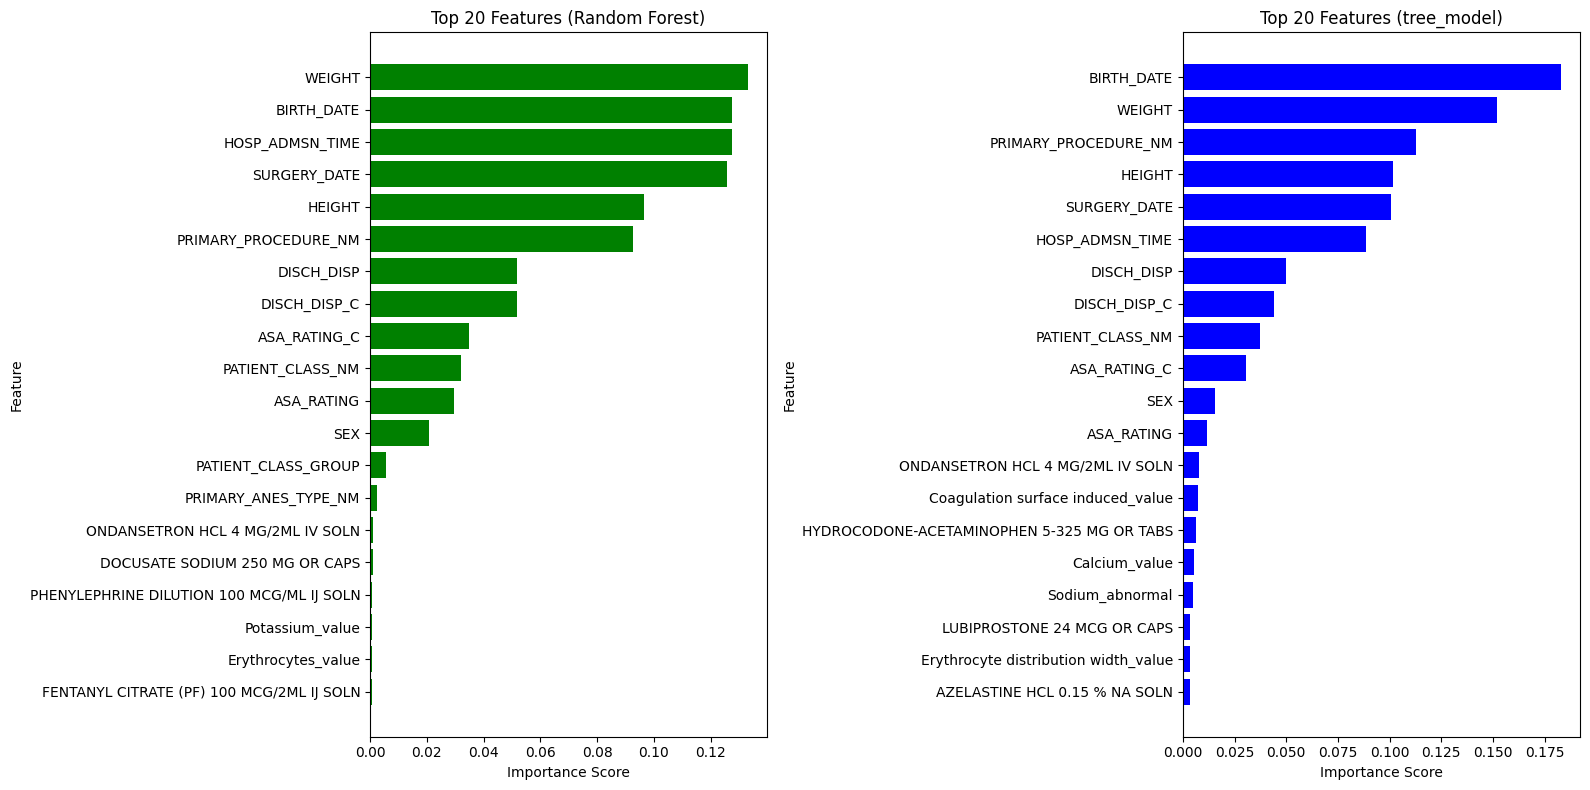

In [613]:
# First Model: RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=1100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importances for the first model
importances_rf = rf_model.feature_importances_
feature_names_rf = X.columns  # Assuming feature names are in X_train.columns

# Create a DataFrame with feature names and importances for the first model
feature_importances_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': importances_rf})

# Sort the DataFrame by importance descending
feature_importances_rf = feature_importances_rf.sort_values('importance', ascending=False)

# Select top N features for the first model
top_n = 20
top_features_rf = feature_importances_rf.head(top_n)

# Second Model: tree_model (assuming it's already defined and trained)
importances_tree = tree_model.feature_importances_
feature_names_tree = X.columns  # Assuming feature names are in X_train.columns

# Create a DataFrame with feature names and importances for the second model
feature_importances_tree = pd.DataFrame({'feature': feature_names_tree, 'importance': importances_tree})

# Sort the DataFrame by importance descending
feature_importances_tree = feature_importances_tree.sort_values('importance', ascending=False)

# Select top N features for the second model
top_features_tree = feature_importances_tree.head(top_n)

# Plotting both graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First subplot (Random Forest)
axes[0].barh(top_features_rf['feature'][::-1], top_features_rf['importance'][::-1], color='green')
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Feature')
axes[0].set_title(f'Top {top_n} Features (Random Forest)')

# Second subplot (tree_model)
axes[1].barh(top_features_tree['feature'][::-1], top_features_tree['importance'][::-1], color='blue')
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('Feature')
axes[1].set_title(f'Top {top_n} Features (tree_model)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Additional Exploration: Hyperparmeter Finetuning

In this section, I will try hyparameter tuning for a Random Forest model using GridSearchCV or RandomizedSearchCV in scikit-learn. The only fixed hyperparmeter here is tree size, which will be set to 1100, as it was tested to be the best performing setting.

As a baseline reference, the RF model with 1100 tree without any hyperparameter fine tuning has an accuacy of 61.0% accuracy. So as we look at the table below, even after grid searching combinations of hyperparammeters, the accuracy remains the same, indicating that the performance bottleneck is caused by the dataset and ineffectiveness of the algorithm itself.

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [1100],
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],      
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]      
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           scoring='accuracy',  # You can use other scoring metrics as needed
                           cv=5,               # 5-fold cross-validation
                           verbose=2,          # Increase verbosity to see the process
                           n_jobs=-1)          # Use all available cores for faster computation

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

# Test the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

In [626]:

# Evaluate the performance on the test set
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print("Classification Report:\n", report)

Test Accuracy: 0.6103896103896104
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.63      0.38      0.47        96
           2       0.60      0.87      0.71       121

    accuracy                           0.61       231
   macro avg       0.41      0.41      0.39       231
weighted avg       0.58      0.61      0.57       231



### Potential Improvememts on the Model
#### Dataset Engineering
To improve the model’s performance, particularly in terms of precision(since it is the more important aspact we want to focus on, concluded on analysis in precision&recall graph section), several strategies can be considered. First, addressing the class imbalance in the dataset is crucial, beause it is likely to be the main contributer to the lower precision. Techniques such as class weighting during model training or resampling methods (oversampling the minority class or undersampling the majority class) can help the model better distinguish between the different complication outcomes. 

#### Different Tree Algorithm
Experimenting with alternative algorithms, such as Gradient Boosting Machines (GBMs) or XGBoost, may also lead to better performance by allowing the model to more effectively capture complex relationships in the data. 

#### Finetuning Hyperparameters
Fine-tuning hyperparameters, such as the maximum depth of trees, the minimum number of samples per split, or the number of features considered at each split, could help reduce overfit and improve generalization. 

One critical parameter is max_depth, which controls the depth of each tree. While deeper trees can capture more complex patterns, they are also more prone to overfitting, so limiting tree depth can help reduce this risk.

Another core hyperparameter is max_features, which determines the number of features considered when making a split at each node. By reducing the number of features, we could indirectly increase the randomness of the trees, making them less correlated and improving overall generalization. 